# FDA Recall Classification Pipeline: Model Development and Evaluation
**By Lorena Dorado & Parisa Kamizi**

- This notebook implements modeling with multiple algorithms (Logistic Regression, Decision Tree, Random Forest, XGBoost, MLP).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import randint, uniform, sem, t
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc,
    roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils import resample
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter, defaultdict

In [2]:
# Create directories for saving results and cached models
os.makedirs('results', exist_ok=True)
os.makedirs('results/baseline', exist_ok=True)
os.makedirs('results/hybrid', exist_ok=True)
os.makedirs('cache', exist_ok=True)

In [3]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
dataset_type = 'baseline'

# Load Data

In [21]:
# Load the dataset
train_path = f'../data/train_{dataset_type}.csv'
test_path = f'../data/test_{dataset_type}.csv'
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Loaded {dataset_type} datasets:")
    print(f"Training shape: {train_df.shape}")
    print(f"Testing shape: {test_df.shape}")
    print("Test set proportion: {:.2f}%".format(100 * X_test.shape[0] / (X_train.shape[0] + X_test.shape[0])))
except FileNotFoundError:
    print(f"Error: {dataset_type} datasets not found. Please run Data Processing Notebook.ipynb")
    raise SystemExit("Aborting execution.")
else:
    # Basic dataset information
    print("\nTraining Dataset Overview:")
    print(f"Columns: {len(train_df.columns)}")

Loaded baseline datasets:
Training shape: (31492, 42)
Testing shape: (7874, 42)
Test set proportion: 20.00%

Training Dataset Overview:
Columns: 42


## Data Cleaning (Validation)

In [15]:
# Check for missing values
missing = train_df.isnull().sum()
missing = missing[missing > 0]

print(f"Missing values in training data: {missing}" if not missing.empty else "No missing values in training data")

No missing values in training data


## Data Preparation

In [16]:
# Define features (X) and target (y)
X_train = train_df.drop(target_col, axis=1)
y_train = train_df[target_col]
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]

In [17]:
# Check test data has the same columns as train data
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

In [18]:
# Encode target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
class_names = le.classes_
print(f"Target Classes: {class_names}")
print(f"Encoded as: {np.unique(y_train_encoded)}")

Target Classes: ['Class I' 'Class II' 'Class III']
Encoded as: [0 1 2]


## Train-Test Split Validation

In [23]:
# Class distribution analysis
train_class_counts = pd.Series(y_train_encoded).value_counts()
test_class_counts = pd.Series(y_test_encoded).value_counts()
print("\nTraining class distribution (counts):")
print(train_class_counts)
print("\nTraining class distribution (percentages):")
print(pd.Series(y_train_encoded).value_counts(normalize=True) * 100)
print("\nTest class distribution (counts):")
print(test_class_counts)
print("\nTest class distribution (percentages):")
print(pd.Series(y_test_encoded).value_counts(normalize=True) * 100)


Training class distribution (counts):
1    22619
0     6684
2     2189
Name: count, dtype: int64

Training class distribution (percentages):
1    71.824590
0    21.224438
2     6.950972
Name: proportion, dtype: float64

Test class distribution (counts):
1    5655
0    1671
2     548
Name: count, dtype: int64

Test class distribution (percentages):
1    71.818644
0    21.221742
2     6.959614
Name: proportion, dtype: float64


In [24]:
# Display number of features
print(f"\nNumber of features: {X_train.shape[1]}")


Number of features: 41


In [25]:
# Display feature categories
temporal_features = [col for col in X_train.columns if any(x in col for x in ['Month', 'Day', 'Year', 'Week'])]
categorical_features = [col for col in X_train.columns if any(x in col for x in ['Type', 'Status', 'Region', 'DistScope'])]
flag_features = [col for col in X_train.columns if any(x in col for x in ['has_', 'allergen_', 'possible_'])]
print(f"Temporal features: {len(temporal_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Flag features: {len(flag_features)}")
print(f"Other features: {X_train.shape[1] - len(temporal_features) - len(categorical_features) - len(flag_features)}")

Temporal features: 5
Categorical features: 16
Flag features: 19
Other features: 1


Pre-processed Dataset Validation: Checking infinity or NaN values

In [26]:
# Check for issues
inf_count = np.isinf(X_train.values).sum()
nan_count = np.isnan(X_train.values).sum()
if inf_count > 0 or nan_count > 0:
    print(f"Warning: Found {inf_count} infinity values and {nan_count} NaN values")
    # Handle issues
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    print("No infinity or NaN values found.")

No infinity or NaN values found.


# Modeling with Cross Validation

The models selected includ logistic regression (logreg), decision tree, random forest, xgboost, and multi-layer perceptron (mlp)

In [27]:
# Define models
models = {
    'logreg': {
        'model': LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
        'param_grid': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2']
        },
        'needs_scaling': True,
        'feature_selector': SelectFromModel
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'model__max_depth': [5, 10, 15, 20, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'needs_scaling': False,
        'feature_selector': SelectFromModel
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        },
        'needs_scaling': False,
        'feature_selector': SelectFromModel
    },
    'xgboost': {
        'model': XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 6],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        },
        'needs_scaling': False,
        'feature_selector': SelectFromModel
    },
    'mlp': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'param_grid': {
            'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'model__activation': ['relu', 'tanh'],
            'model__alpha': [0.0001, 0.001],
            'model__learning_rate': ['constant', 'adaptive']
        },
        'needs_scaling': True,
        'feature_selector': SelectKBest
    }
}

In [28]:
# Define number of features
n_features_options = [5, 10, 15, 20, 'all']  # 'all' = no feature selection

In [29]:
# Define number of cross-validation folds
n_cv_folds = 5

Stratified k-fold for consistent fold splitting

In [30]:
# Define skf
skf = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=42)

Store results

In [31]:
# Results Dictionary
results = defaultdict(list)
best_configs = {}

Track feature selection frequencies

In [32]:
# Create Dictionary
feature_importance = pd.DataFrame(0, index=X_train.columns, columns=list(models.keys()))

Iterate through each model

Normalize feature importance by number of folds

In [33]:
# Used ChatGPT to create this code that loops through a set of machine learning models
for model_name, model_config in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    
    model_best_score = 0
    model_best_config = None
    model_best_features = None
    
    # Iterate through different feature selection options
    for n_features in n_features_options:
        print(f"  Testing with feature selection: {n_features}")
        
        # Scores across folds
        fold_scores = []
        fold_feature_importances = []
        
        # Iterate through each fold
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
            print(f"    Fold {fold_idx+1}/{n_cv_folds}")
            
            # Split data into training and validation sets for this fold
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train_encoded[train_idx], y_train_encoded[val_idx]
            
            # Apply SMOTE only to the training portion of this fold
            sm = SMOTE(random_state=42)
            X_fold_train_resampled, y_fold_train_resampled = sm.fit_resample(X_fold_train, y_fold_train)
            
            # Define steps for the pipeline, conditionally including scaling
            steps = []
            
            # Add scaling if needed
            if model_config['needs_scaling']:
                steps.append(('scaler', StandardScaler()))
            
            # Add feature selection unless n_features is 'all'
            if n_features != 'all':
                if model_config['feature_selector'] == SelectKBest:
                    steps.append(('feature_selection', SelectKBest(f_classif, k=n_features)))
                else:
                    steps.append(('feature_selection', model_config['feature_selector'](model_config['model'], max_features=n_features)))
            
            # Add the model
            steps.append(('model', model_config['model']))
            
            # Create pipeline
            pipeline = Pipeline(steps)
            
            # Create grid search for hyperparameter tuning
            grid_search = GridSearchCV(
                pipeline,
                param_grid=model_config['param_grid'],
                cv=3,  # Use 3-fold CV for hyperparameter tuning within this fold
                scoring='f1_weighted',
                n_jobs=-1,
                verbose=0
            )
            
            # Train with grid search
            grid_search.fit(X_fold_train_resampled, y_fold_train_resampled)
            
            # Get best model
            best_fold_model = grid_search.best_estimator_
            
            # Predict on validation fold
            y_fold_pred = best_fold_model.predict(X_fold_val)
            
            # Calculate F1 score
            fold_f1_score = f1_score(y_fold_val, y_fold_pred, average='weighted')
            fold_scores.append(fold_f1_score)
            
            # Track feature importance for this fold
            if n_features != 'all' and 'feature_selection' in best_fold_model.named_steps:
                feature_selector = best_fold_model.named_steps['feature_selection']
                if hasattr(feature_selector, 'get_support'):
                    support = feature_selector.get_support()
                    # Track which features were selected
                    selected_features = X_train.columns[support]
                    fold_feature_importances.append(selected_features)
            
            print(f"      Best params: {grid_search.best_params_}")
            print(f"      Validation F1 Score: {fold_f1_score:.4f}")
        
        # Calculate mean score across folds
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        print(f"  Mean F1 Score for {n_features} features: {mean_score:.4f} (±{std_score:.4f})")
        
        # Store results
        results[model_name].append({
            'n_features': n_features,
            'mean_f1': mean_score,
            'std_f1': std_score,
            'fold_scores': fold_scores
        })
        
        # Update best configuration if this is better
        if mean_score > model_best_score:
            model_best_score = mean_score
            model_best_config = {
                'n_features': n_features,
                'parameters': grid_search.best_params_
            }
            
            # Track most frequently selected features
            if n_features != 'all' and fold_feature_importances:
                # Count feature occurrences across folds
                feature_counts = {}
                for features in fold_feature_importances:
                    for feature in features:
                        if feature in feature_counts:
                            feature_counts[feature] += 1
                        else:
                            feature_counts[feature] = 1
                
                # Sort by frequency
                sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
                model_best_features = [f[0] for f in sorted_features[:n_features]]
                
                # Update feature importance tracking
                for feature, count in feature_counts.items():
                    feature_importance.loc[feature, model_name] += count
    
    # Store the best configuration for this model
    best_configs[model_name] = {
        'config': model_best_config,
        'best_score': model_best_score,
        'best_features': model_best_features
    }
    
    print(f"\nBest configuration for {model_name}:")
    print(f"  Number of features: {model_best_config['n_features']}")
    print(f"  Best parameters: {model_best_config['parameters']}")
    print(f"  Best CV F1 Score: {model_best_score:.4f}")
    
    if model_best_features:
        print(f"  Most important features: {', '.join(model_best_features[:5])}")


Training and evaluating logreg...
  Testing with feature selection: 5
    Fold 1/5
      Best params: {'model__C': 0.01, 'model__penalty': 'l2'}
      Validation F1 Score: 0.5934
    Fold 2/5
      Best params: {'model__C': 0.01, 'model__penalty': 'l2'}
      Validation F1 Score: 0.5917
    Fold 3/5
      Best params: {'model__C': 0.01, 'model__penalty': 'l2'}
      Validation F1 Score: 0.5915
    Fold 4/5
      Best params: {'model__C': 0.01, 'model__penalty': 'l1'}
      Validation F1 Score: 0.5978
    Fold 5/5
      Best params: {'model__C': 0.01, 'model__penalty': 'l1'}
      Validation F1 Score: 0.5904
  Mean F1 Score for 5 features: 0.5930 (±0.0026)
  Testing with feature selection: 10
    Fold 1/5
      Best params: {'model__C': 100, 'model__penalty': 'l1'}
      Validation F1 Score: 0.6704
    Fold 2/5
      Best params: {'model__C': 1, 'model__penalty': 'l2'}
      Validation F1 Score: 0.5837
    Fold 3/5
      Best params: {'model__C': 1, 'model__penalty': 'l2'}
      Valida

In [34]:
# Divide each feature count by number of CV folds
feature_importance = feature_importance / n_cv_folds

#### Model Comparison

In [76]:
# Train individual models with their best configurations from CV
models_to_compare = {}

In [77]:
# For each model, train using its best configuration from cross-validation
for model_name, model_config in best_configs.items():
    print(f"Training final {model_name} model for comparison...")
    
    # Define steps for the pipeline
    steps = []
    
    # Add scaling if needed
    if models[model_name]['needs_scaling']:
        steps.append(('scaler', StandardScaler()))
    
    # Add feature selection unless n_features is 'all'
    if model_config['config']['n_features'] != 'all':
        if models[model_name]['feature_selector'] == SelectKBest:
            steps.append(('feature_selection', 
                          SelectKBest(f_classif, k=model_config['config']['n_features'])))
        else:
            steps.append(('feature_selection', 
                          models[model_name]['feature_selector'](models[model_name]['model'], 
                                                                max_features=model_config['config']['n_features'])))
    
    # Add the model with best parameters
    # Extract model parameters
    best_params = {k.replace('model__', ''): v for k, v in model_config['config']['parameters'].items()}
    model_instance = models[model_name]['model'].__class__(**best_params)
    steps.append(('model', model_instance))
    
    # Create and train pipeline
    pipeline = Pipeline(steps)
    pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Store pipeline and predictions
    models_to_compare[model_name] = {
        'pipeline': pipeline,
        'pred': y_pred
    }
    
    # Save model
    joblib.dump(pipeline, f'results/{dataset_type}/final_models/{model_name}_final_model.joblib')

Training final logreg model for comparison...
Training final decision_tree model for comparison...
Training final random_forest model for comparison...
Training final xgboost model for comparison...
Training final mlp model for comparison...


#### Collect all metrics for comparison

In [78]:
# Calculate metrics for each model
for name, model_dict in models_to_compare.items():
    preds = model_dict['pred']
    model_dict['accuracy'] = accuracy_score(y_test_encoded, preds)
    model_dict['precision'] = precision_score(y_test_encoded, preds, average='weighted')
    model_dict['recall'] = recall_score(y_test_encoded, preds, average='weighted')
    model_dict['f1'] = f1_score(y_test_encoded, preds, average='weighted')
    
    # Class-specific metrics
    model_dict['class_reports'] = classification_report(y_test_encoded, preds, 
                                                     target_names=class_names, 
                                                     output_dict=True)

In [79]:
# Create comparison DataFrame
metrics_df = pd.DataFrame({
    'Model': list(models_to_compare.keys()),
    'Accuracy': [model_dict['accuracy'] for model_dict in models_to_compare.values()],
    'Precision': [model_dict['precision'] for model_dict in models_to_compare.values()],
    'Recall': [model_dict['recall'] for model_dict in models_to_compare.values()],
    'F1 Score': [model_dict['f1'] for model_dict in models_to_compare.values()]
})

In [80]:
# Sort by F1 Score
metrics_df = metrics_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

In [81]:
# Display the comparison
print("\nModel Performance Comparison:")
print(metrics_df.to_string(index=False, float_format='%.4f'))


Model Performance Comparison:
        Model  Accuracy  Precision  Recall  F1 Score
random_forest    0.9328     0.9305  0.9328    0.9311
decision_tree    0.9110     0.9125  0.9110    0.9116
          mlp    0.8748     0.8903  0.8748    0.8807
      xgboost    0.8760     0.8794  0.8760    0.8774
       logreg    0.6562     0.7711  0.6562    0.6931


In [82]:
# Save to CSV
metrics_df.to_csv(f'results/{dataset_type}/model_comparison.csv', index=False)

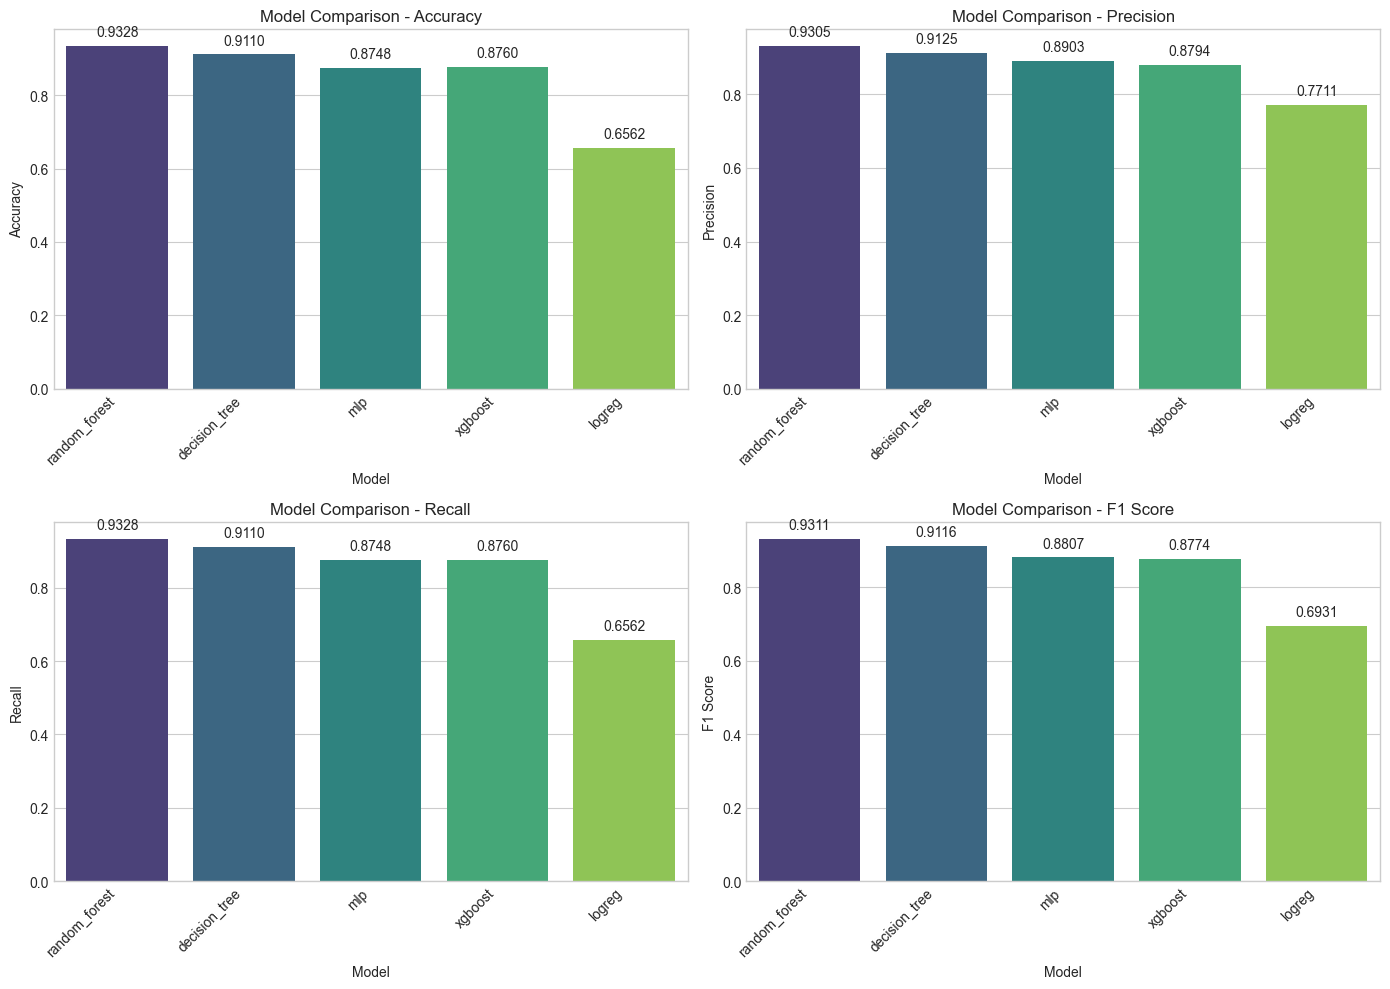

In [86]:
# Visualize the comparison
plt.figure(figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot each metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels to bars
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/model_metrics_comparison.png', dpi=300)
plt.show()
plt.close()

In [87]:
# Generate detailed class-specific comparison
class_metrics = {}
for class_idx, class_name in enumerate(class_names):
    class_metrics[class_name] = {
        'Model': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }
    
    for model_name, model_dict in models_to_compare.items():
        class_report = model_dict['class_reports'][class_name]
        class_metrics[class_name]['Model'].append(model_name)
        class_metrics[class_name]['Precision'].append(class_report['precision'])
        class_metrics[class_name]['Recall'].append(class_report['recall'])
        class_metrics[class_name]['F1 Score'].append(class_report['f1-score'])

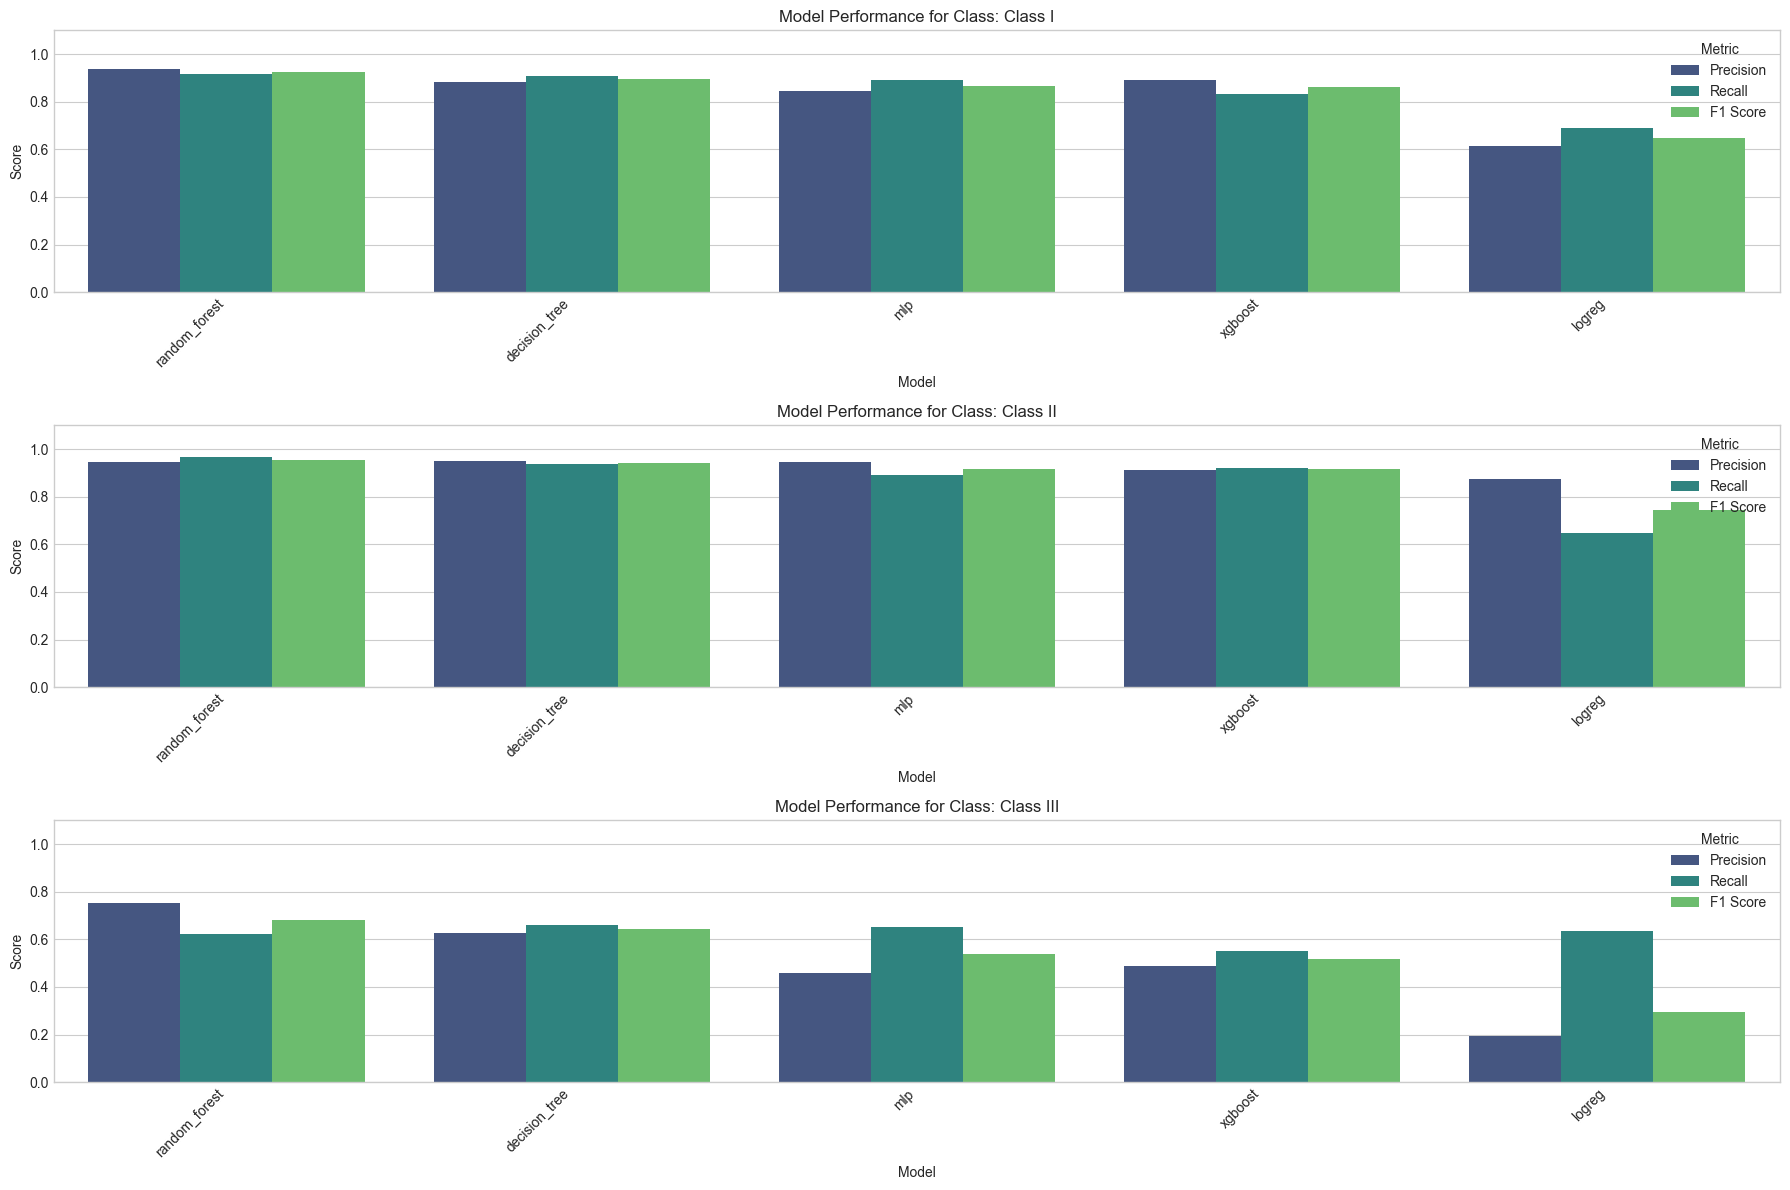

In [88]:
# Plot class-specific performance for each model
plt.figure(figsize=(18, 12))
for i, class_name in enumerate(class_names):
    # Create DataFrame for this class
    df = pd.DataFrame(class_metrics[class_name])
    df = df.sort_values('F1 Score', ascending=False)
    
    plt.subplot(len(class_names), 1, i+1)
    
    # Melt the DataFrame for easier plotting
    df_melted = pd.melt(df, id_vars=['Model'], value_vars=['Precision', 'Recall', 'F1 Score'],
                        var_name='Metric', value_name='Value')
    
    # Plot grouped bar chart
    sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted, palette='viridis')
    
    plt.title(f'Model Performance for Class: {class_name}')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.legend(title='Metric')

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/class_specific_performance.png', dpi=300)
plt.show()
plt.close()

In [89]:
# Save class-specific metrics to CSV
for class_name, metrics in class_metrics.items():
    pd.DataFrame(metrics).to_csv(f'results/{dataset_type}/metrics_{class_name.replace(" ", "_")}.csv', index=False)

Find overall best model

In [35]:
# Find model with highest F1 score
best_model_name = max(best_configs, key=lambda k: best_configs[k]['best_score'])
best_model_score = best_configs[best_model_name]['best_score']
best_model_config = best_configs[best_model_name]['config']
best_model_features = best_configs[best_model_name]['best_features']

In [36]:
print(f"\nOverall best model: {best_model_name}")
print(f"Best CV F1 Score: {best_model_score:.4f}")
print(f"Best configuration: {best_model_config}")


Overall best model: random_forest
Best CV F1 Score: 0.9215
Best configuration: {'n_features': 'all', 'parameters': {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}}


Visualize model comparison

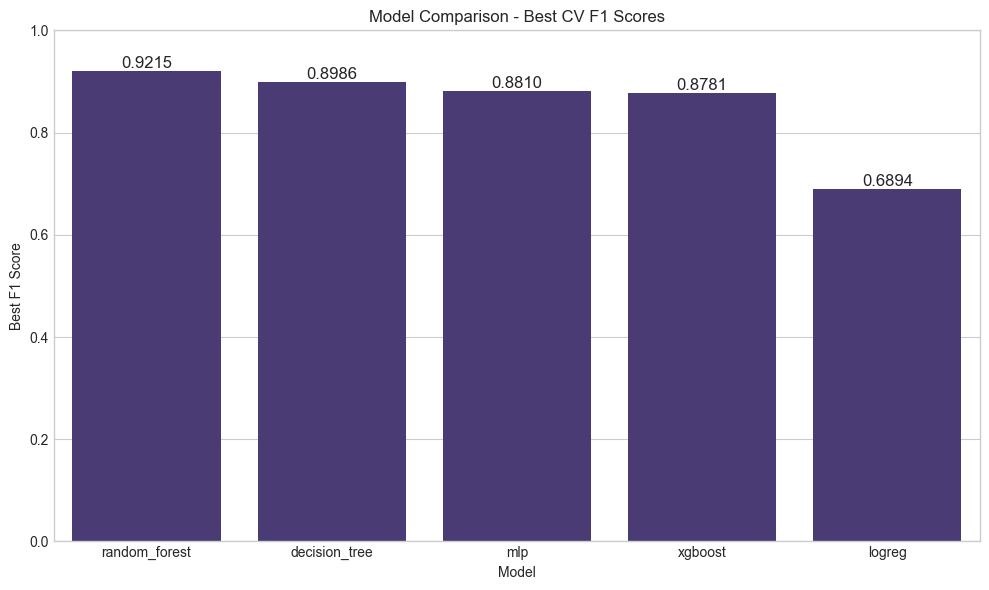

In [37]:
# Create dataframe of model and F1 scores to compare
model_comparison = pd.DataFrame([
    {'Model': model_name, 'Best F1 Score': config['best_score']}
    for model_name, config in best_configs.items()
])
model_comparison = model_comparison.sort_values('Best F1 Score', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Best F1 Score', data=model_comparison)
plt.title('Model Comparison - Best CV F1 Scores')
plt.ylim(0, 1.0)

# Add score labels
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(f'results/{dataset_type}/model_comparison_cv.png', dpi=300)
plt.show()
plt.close()

# Final Model Training and Evaluation

In [38]:
# Get best model configuration
best_config = best_configs[best_model_name]['config']
best_params = {k.replace('model__', ''): v for k, v in best_config['parameters'].items()}

## Train Final Model

In [39]:
# Apply SMOTE to full training set
print("Applying SMOTE to full training set...")
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train_encoded)

print(f"{best_model_name}")

Applying SMOTE to full training set...
random_forest


#### Create final pipeline

In [40]:
# list steps for pipeline
final_steps = []

# Scaling
if models[best_model_name]['needs_scaling']:
    final_steps.append(('scaler', StandardScaler()))

# Feature selection
if best_config['n_features'] != 'all':
    if models[best_model_name]['feature_selector'] == SelectKBest:
        final_steps.append(('feature_selection', SelectKBest(f_classif, k=best_config['n_features'])))
    else:
        final_steps.append(('feature_selection', models[best_model_name]['feature_selector'](
            models[best_model_name]['model'], max_features=best_config['n_features']
        )))

#### Create the model with best parameters

In [41]:
# Configure new instance for best model
model_instance = models[best_model_name]['model'].__class__(**best_params)
final_steps.append(('model', model_instance))

In [42]:
#### Build and train final pipeline

In [43]:
# Train final model with preprocessing and selection steps on balanced data
final_pipeline = Pipeline(final_steps)
final_pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('model', RandomForestClassifier(n_estimators=200))])

In [44]:
# Save the final model
os.makedirs(f'results/{dataset_type}/final_models', exist_ok=True)
joblib.dump(final_pipeline, f'results/{dataset_type}/final_models/{best_model_name}_final_model.joblib')
joblib.dump(le, f'results/{dataset_type}/final_models/label_encoder.joblib')

['results/baseline/final_models/label_encoder.joblib']

## Final Model Evaluation on Test Set

In [45]:
# Predict on test set
y_pred = final_pipeline.predict(X_test)

#### Classification Report

In [46]:
print(classification_report(y_test_encoded, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Class I       0.94      0.92      0.93      1671
    Class II       0.95      0.97      0.96      5655
   Class III       0.76      0.64      0.69       548

    accuracy                           0.93      7874
   macro avg       0.88      0.84      0.86      7874
weighted avg       0.93      0.93      0.93      7874



#### Confusion matrix

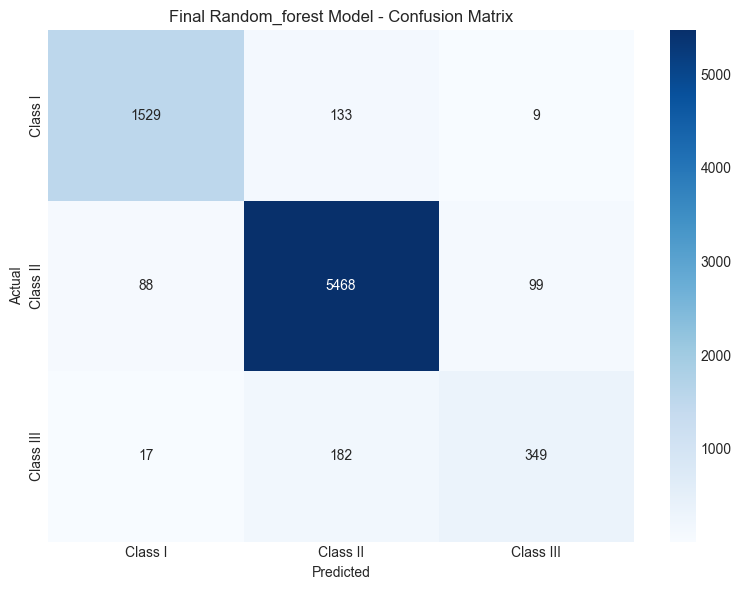

In [47]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Final {best_model_name.capitalize()} Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f'results/{dataset_type}/final_model_confusion_matrix.png', dpi=300)
plt.show()
plt.close()

#### Evaluation Metrics

In [48]:
# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"\nFinal Model Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Final Model Test Metrics:
Accuracy: 0.9329
Precision: 0.9308
Recall: 0.9329
F1 Score: 0.9314


#### Class-specific Metrics

In [49]:
# Loop through each class in target variable and compute Precision, Recall, F1 score
for i, class_name in enumerate(class_names):
    class_precision = precision_score(y_test_encoded, y_pred, labels=[i], average=None)[0]
    class_recall = recall_score(y_test_encoded, y_pred, labels=[i], average=None)[0]
    class_f1 = f1_score(y_test_encoded, y_pred, labels=[i], average=None)[0]
    
    print(f"{class_name}:")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall: {class_recall:.4f}")
    print(f"  F1 Score: {class_f1:.4f}")

Class I:
  Precision: 0.9357
  Recall: 0.9150
  F1 Score: 0.9253
Class II:
  Precision: 0.9455
  Recall: 0.9669
  F1 Score: 0.9561
Class III:
  Precision: 0.7637
  Recall: 0.6369
  F1 Score: 0.6945


#### ROC Curves

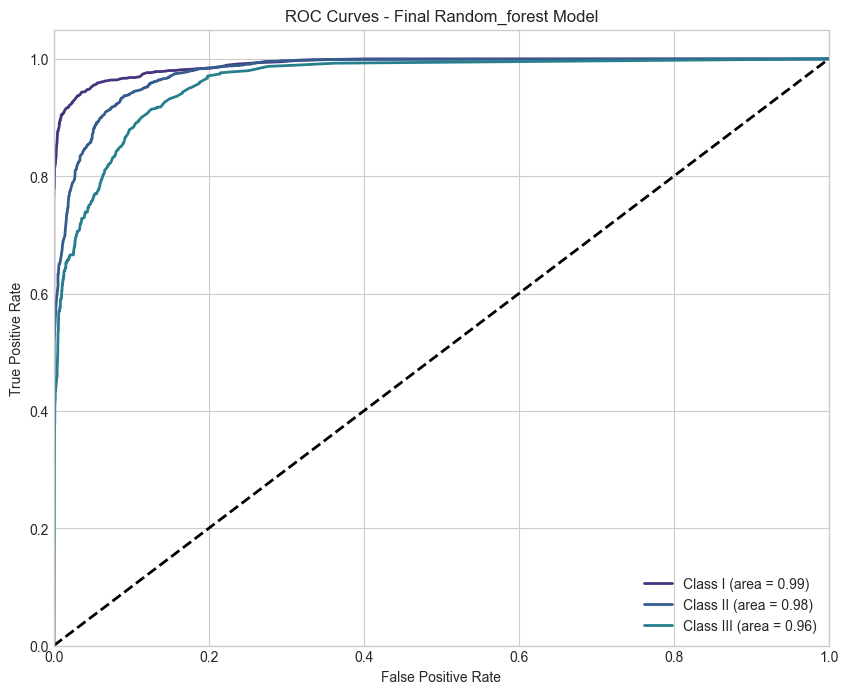

In [50]:
# If model supports predict_proba, then get predicted variable for each class
if hasattr(final_pipeline, 'predict_proba'):
    y_proba = final_pipeline.predict_proba(X_test)
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    # For each class
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_encoded == i, y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - Final {best_model_name.capitalize()} Model')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'results/{dataset_type}/final_model_roc_curves.png', dpi=300)
    plt.show()
    plt.close()

# Feature Importance Analysis


Top 10 most important features:
                   Feature  Importance
         Reason_Word_Count    0.138663
                 Month_sin    0.078930
                 Month_cos    0.073870
         Years_Since_First    0.068074
ProductType_Food/Cosmetics    0.063366
             DayOfWeek_sin    0.058912
       ProductType_Devices    0.053949
             DayOfWeek_cos    0.046201
              has_listeria    0.040740
           DistScope_Other    0.037169


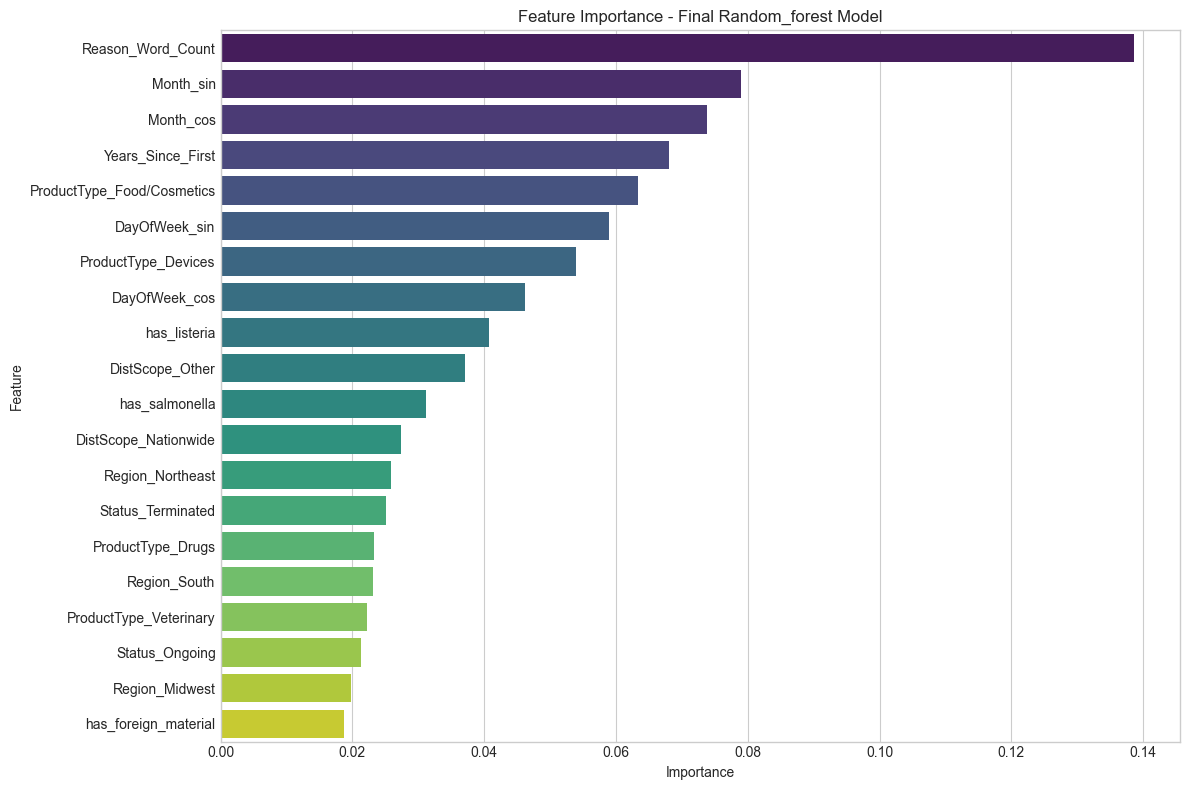

In [51]:
# Used ChatGPT to streamline the analysis and visualization of feature importance
if hasattr(final_pipeline.named_steps['model'], 'feature_importances_'):
    # For tree-based models that have feature_importances_
    if 'feature_selection' in final_pipeline.named_steps:
        # Get selected features
        mask = final_pipeline.named_steps['feature_selection'].get_support()
        selected_features = X_train.columns[mask]
        importances = final_pipeline.named_steps['model'].feature_importances_
        
        # Create DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    else:
        # All features were used
        importances = final_pipeline.named_steps['model'].feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title(f"Feature Importance - Final {best_model_name.capitalize()} Model")
    plt.tight_layout()
    plt.savefig(f'results/{dataset_type}/final_model_feature_importance.png', dpi=300)
    plt.show()
    plt.close()
    
    # Save feature importance to CSV
    importance_df.to_csv(f'results/{dataset_type}/final_model_feature_importance.csv', index=False)
elif hasattr(final_pipeline.named_steps['model'], 'coef_'):
    # For models like Logistic Regression that have coefficients
    if 'feature_selection' in final_pipeline.named_steps:
        # Get selected features
        mask = final_pipeline.named_steps['feature_selection'].get_support()
        selected_features = X_train.columns[mask]
        
        # For multi-class, take mean absolute coefficient values
        coef = final_pipeline.named_steps['model'].coef_
        if coef.ndim > 1:
            importances = np.mean(np.abs(coef), axis=0)
        else:
            importances = np.abs(coef)
        
        # Create DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    else:
        # All features were used
        coef = final_pipeline.named_steps['model'].coef_
        if coef.ndim > 1:
            importances = np.mean(np.abs(coef), axis=0)
        else:
            importances = np.abs(coef)
        
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title(f"Feature Importance - Final {best_model_name.capitalize()} Model")
    plt.tight_layout()
    plt.savefig(f'results/{dataset_type}/final_model_feature_importance.png', dpi=300)
    plt.show()
    plt.close()
    
    # Save feature importance to CSV
    importance_df.to_csv(f'results/{dataset_type}/final_model_feature_importance.csv', index=False)
else:
    # Use the cross-validation feature importance tracking
    print("\nFeature importance based on selection frequency during cross-validation:")
    
    # Normalize by model count
    avg_importance = feature_importance.mean(axis=1)
    importance_df = pd.DataFrame({
        'Feature': feature_importance.index,
        'Selection Frequency': avg_importance
    }).sort_values('Selection Frequency', ascending=False)
    
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Selection Frequency', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title("Feature Selection Frequency Across Models")
    plt.tight_layout()
    plt.savefig(f'results/{dataset_type}/feature_selection_frequency.png', dpi=300)
    plt.show()
    plt.close()
    
    # Save feature importance to CSV
    importance_df.to_csv(f'results/{dataset_type}/feature_selection_frequency.csv', index=False)

# Summary and Conclusions

#### Class-specific test performance

In [52]:
# Create class-specific performance DataFrame
class_report = classification_report(y_test_encoded, y_pred, target_names=class_names, output_dict=True)
class_df = pd.DataFrame()

for class_name in class_names:
    class_df.loc[class_name, 'f1-score'] = class_report[class_name]['f1-score']
    class_df.loc[class_name, 'precision'] = class_report[class_name]['precision']
    class_df.loc[class_name, 'recall'] = class_report[class_name]['recall']

class_df = class_df.sort_values('f1-score', ascending=False)
print(class_df)

           f1-score  precision    recall
Class II   0.956111   0.945530  0.966932
Class I    0.925265   0.935741  0.915021
Class III  0.694527   0.763676  0.636861


#### Best and Worst Performing Classes

In [53]:
# Select first (best) and last (worst) index
best_class = class_df.index[0]
worst_class = class_df.index[-1]

print(f"\nBest performing class: {best_class} (F1: {class_df.loc[best_class, 'f1-score']:.4f})")
print(f"Worst performing class: {worst_class} (F1: {class_df.loc[worst_class, 'f1-score']:.4f})")


Best performing class: Class II (F1: 0.9561)
Worst performing class: Class III (F1: 0.6945)


In [54]:
#### Save Summary into JSON file

In [55]:
# Summary dictionary
summary = {
    'dataset_type': dataset_type,
    'best_model': best_model_name,
    'best_cv_f1': float(best_model_score),
    'test_f1': float(f1),
    'best_class': best_class,
    'best_class_f1': float(class_df.loc[best_class, 'f1-score']),
    'worst_class': worst_class,
    'worst_class_f1': float(class_df.loc[worst_class, 'f1-score']),
    'best_features': best_model_features[:10] if best_model_features else None,
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'results/{dataset_type}/modeling_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

In [56]:
print(f"\nModeling process completed for {dataset_type} dataset.")
print(f"Best model: {best_model_name}")
print(f"Best CV F1 Score: {best_model_score:.4f}")
print(f"Test F1 Score: {f1:.4f}")

if best_model_features:
    print(f"Top 5 most important features: {', '.join(best_model_features[:5])}")


Modeling process completed for baseline dataset.
Best model: random_forest
Best CV F1 Score: 0.9215
Test F1 Score: 0.9314
Top 5 most important features: Month_sin, Month_cos, DayOfWeek_sin, DayOfWeek_cos, Years_Since_First
